# Exploration of the King County Housing Dataset

My goal in this notebook is to provide plauseable insight into ways a homeowner can make renovations to their current home in order to make it more attactive to buyers and/or sell for a high price.

Let's first import some tools and take our first look at the dataset

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
%matplotlib inline
df = pd.read_csv("data/kc_house_data.csv")
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [2]:
# This code is to give a print() of all cloumns in the dataset
# in a vertical format
# since there are too many columns to show in the df in one place
# warpped code

dfList = list(df.columns)
dfList

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

# Cleaning and Prepping the data 

Sweet. Now that we can get a good look at what we're working with we will start to clean the data a bit to get it ready for modeling. First, we can already start to eliminate some columns that are irrelevant.
Here's what we can get rid of:

- **id** - the specific id of the house doesn't matter, we just need the data from it to make a model
- **date** - like id, date sold doesn't matter, we just need the data about the house to make a model
- **view** - this is not about the view from the house but how many times it had been view. Not particularly useful
- **zipcode** - this is only helpful if we have information about how safe the neighborhood is. We do not so we will ignore this one
- **lat** - latitude of the house isn't quite as usful as an address
- **long** - like with lat, longitude of a house isn't quite as usful as an address
* **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors. Not usful
* **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors. Not usful

In [3]:
df.drop(['id', 'date', 'view', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

In [4]:
dfListDrop = list(df.columns)
dfListDrop

['price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated']

Awesome! Now, let's take a look at our data and see if any columns have NaN (missing) values that might get in the way.

In [5]:
df.isna().sum()

price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
dtype: int64

Okay, it looks like we have a couple. Let's take a closer look...

In [6]:
print(df['waterfront'].value_counts())
print('column "waterfront" has', df['waterfront'].isna().sum(), 'NaNRRR values')

0.0    19075
1.0      146
Name: waterfront, dtype: int64
column "waterfront" has 2376 NaNRRR values


In [7]:
print(df['yr_renovated'].value_counts())
print('column "yr_renovated" has', df['yr_renovated'].isna().sum(), 'NaN values')

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64
column "yr_renovated" has 3842 NaN values


When it comes to 'waterfront' it looks like the values are 1 or 0 indicating a 'yes' or 'no' as to whether or not it has a waterfront view. Since there isn't much data here to begin with, and we want as many results as posible, we'll simply replace NaN values with a 0 to assume those homes don't have a waterfront view.

In [8]:
df['waterfront'] = df['waterfront'].fillna(0)

In [9]:
print(df['waterfront'].value_counts())
print('column "waterfront" has', df['waterfront'].isna().sum(), 'NaN values')

0.0    21451
1.0      146
Name: waterfront, dtype: int64
column "waterfront" has 0 NaN values


As far as 'yr_renovated' the values are either meant to have a year for when it was rennovated or a 0 for if it wasn't renovated. Like the with 'waterfront' we have to assume that NaN values in this case just haven't been renovated at all. However, we're going to tweek the data a bit here. It's not so much important *when* the house was renotvated but*if* it was renovated. So we'll change dates to a '1' to indicate a 'yes' or 'no', just like with 'waterfront'

In [10]:
print(df.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated'],
      dtype='object')


In [11]:
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.loc[df.yr_renovated != 0, 'yr_renovated'] = 1

print(df['yr_renovated'].value_counts())
print('column "yr_renovated" has', df['yr_renovated'].isna().sum(), 'NaN values')

0.0    20853
1.0      744
Name: yr_renovated, dtype: int64
column "yr_renovated" has 0 NaN values


Success! Lastly, let's check to make sure all of our columns are either a float or int as our program wont know what to do with anything else

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21597 non-null  float64
 1   bedrooms       21597 non-null  int64  
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  int64  
 4   sqft_lot       21597 non-null  int64  
 5   floors         21597 non-null  float64
 6   waterfront     21597 non-null  float64
 7   condition      21597 non-null  int64  
 8   grade          21597 non-null  int64  
 9   sqft_above     21597 non-null  int64  
 10  sqft_basement  21597 non-null  object 
 11  yr_built       21597 non-null  int64  
 12  yr_renovated   21597 non-null  float64
dtypes: float64(5), int64(7), object(1)
memory usage: 2.1+ MB


Column 'sqft_basement' is an object. Let's see why...

In [13]:
df.sqft_basement.value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
274.0         1
2850.0        1
2196.0        1
704.0         1
3260.0        1
Name: sqft_basement, Length: 304, dtype: int64

There is a '?' somewhere in our dataset. That's not a number so it wont convert away from a string to a float or int. And since we can't just *pReTEnD* that the house *dOEsN't* have a basement when it clearly does, we can't just zero these values out an ignore it because it would skew our data too much. We're going to have to remove these rows entirely. This shouldn't hit the data too hard since there are plent more rows to spare.

In [14]:
# This code removes all rows that have a '?' value in the basement column
index_names = df[ df['sqft_basement'] == '?' ].index
df.drop(index_names, inplace = True)


# I've already explored this data a bit a know that the rest
# of the data shows up as an object but converts to a float without any fuss
df['sqft_basement'] = df['sqft_basement'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21143 non-null  float64
 1   bedrooms       21143 non-null  int64  
 2   bathrooms      21143 non-null  float64
 3   sqft_living    21143 non-null  int64  
 4   sqft_lot       21143 non-null  int64  
 5   floors         21143 non-null  float64
 6   waterfront     21143 non-null  float64
 7   condition      21143 non-null  int64  
 8   grade          21143 non-null  int64  
 9   sqft_above     21143 non-null  int64  
 10  sqft_basement  21143 non-null  float64
 11  yr_built       21143 non-null  int64  
 12  yr_renovated   21143 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.3 MB


Finally, we can start taking a first look at our total dataset and modeling our first substandard model.

In [15]:
# bigplot = sns.pairplot(df)
# bigplot.fig.set_size_inches(10, 10)

In [16]:
xCols = [c for c in df.columns.to_list() if c not in ['price']]

x = df[xCols]
y = df['price']

In [17]:
model = sm.OLS(y, sm.add_constant(x))

In [18]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     3514.
Date:                Sat, 23 Jan 2021   Prob (F-statistic):               0.00
Time:                        13:34:10   Log-Likelihood:            -2.8998e+05
No. Observations:               21143   AIC:                         5.800e+05
Df Residuals:                   21131   BIC:                         5.801e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.496e+06   1.39e+05     46.609      0.000    6.22e+06    6.77e+06
bedrooms      -4.246e+04   2077.101    -20.441      0.000   -4.65e+04   -3.84e+04
bathrooms      4.692e+04   3583.247     13.094      0.000    3.99e+04    5.39e+04
sqft_living     121.3368      2.315     52.415      0.000     116.799     125.874
sqft_lot         -0.2417      0.038     -6.425      0.000      -0.315      -0.168
floors         2.562e+04   3831.261      6.686      0.000    1.81e+04    3.31e+04
waterfront      7.58e+05   1.87e+04     40.607      0.000    7.21e+05    7.95e+05
condition      1.992e+04   2549.718      7.814      0.000    1.49e+04    2.49e+04
grade          1.307e+05   2201.644     59.346      0.000    1.26e+05    1.35e+05
sqft_above       52.4400      2.227     23.551      0.000      48.076      56.804
sqft_basement    68.8967      2.799     24.615      0.000      63.410      74.383
yr_built      -3748.0043     71.389    -52.501      0.000   -3887.931   -3608.077
yr_renovated   2.938e+04   8723.783      3.368      0.001    1.23e+04    4.65e+04
==============================================================================
Omnibus:                    15541.808   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           999827.694
Skew:                           2.940   Prob(JB):                         0.00
Kurtosis:                      36.172   Cond. No.                     4.90e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.7e-20. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

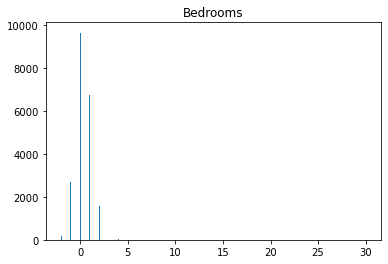

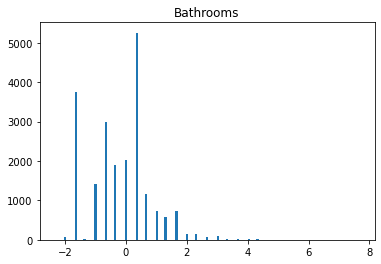

In [19]:
stdScale = StandardScaler()
minMaxScale = MinMaxScaler()
robScale = RobustScaler()

bedroomsScaled = robScale.fit_transform(x['bedrooms'].values.reshape(-1, 1))
bathroomsScaled = robScale.fit_transform(x['bathrooms'].values.reshape(-1, 1))


mmscaled = {'Bedrooms': bedroomsScaled,
           'Bathrooms': bathroomsScaled,
           }

for title, data in mmscaled.items():
    plt.hist(data, bins='auto')
    plt.title(f"{title}")
    plt.show()

In [20]:
print(x.shape)
x.head()

(21143, 12)


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
0,3,1.00,1180,5650,1.0,0.0,3,7,1180,0.0,1955,0.0
1,3,2.25,2570,7242,2.0,0.0,3,7,2170,400.0,1951,1.0
2,2,1.00,770,10000,1.0,0.0,3,6,770,0.0,1933,0.0
3,4,3.00,1960,5000,1.0,0.0,5,7,1050,910.0,1965,0.0
4,3,2.00,1680,8080,1.0,0.0,3,8,1680,0.0,1987,0.0


In [21]:
print(y.shape)
y.head()

(21143,)


0    221900.0
1    538000.0
2    180000.0
3    604000.0
4    510000.0
Name: price, dtype: float64

In [22]:
xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

In [23]:
xTrain.shape

(14165, 12)

In [24]:
xTrain.shape

(14165, 12)

In [25]:
len(xTrain + xTest) == len(x)

True

In [26]:
xTrain.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
20657,2,1.75,1460,1500,2.0,0.0,3,8,1000,460.0,2008,0.0
88,2,2.25,1610,2040,2.0,0.0,4,7,1610,0.0,1979,0.0
15566,4,1.50,3520,4933,1.5,0.0,4,8,2270,1250.0,1929,0.0
20848,4,3.50,3530,8126,2.0,0.0,3,10,3530,0.0,2007,0.0
7299,3,1.75,1390,4602,1.0,0.0,3,7,930,460.0,1981,0.0


In [27]:
XTrainScale = stdScale.fit_transform(xTrain)
XTestScale = stdScale.transform(xTest)

In [28]:
xTrain.values

array([[2.000e+00, 1.750e+00, 1.460e+03, ..., 4.600e+02, 2.008e+03,
        0.000e+00],
       [2.000e+00, 2.250e+00, 1.610e+03, ..., 0.000e+00, 1.979e+03,
        0.000e+00],
       [4.000e+00, 1.500e+00, 3.520e+03, ..., 1.250e+03, 1.929e+03,
        0.000e+00],
       ...,
       [2.000e+00, 1.750e+00, 1.760e+03, ..., 8.800e+02, 1.930e+03,
        0.000e+00],
       [3.000e+00, 2.000e+00, 1.910e+03, ..., 5.000e+02, 1.978e+03,
        0.000e+00],
       [2.000e+00, 1.000e+00, 1.200e+03, ..., 2.200e+02, 1.943e+03,
        0.000e+00]])

In [29]:
xTest.values

array([[3.000e+00, 3.500e+00, 3.070e+03, ..., 1.500e+03, 1.928e+03,
        1.000e+00],
       [3.000e+00, 1.500e+00, 1.430e+03, ..., 4.000e+02, 1.977e+03,
        0.000e+00],
       [4.000e+00, 2.500e+00, 2.980e+03, ..., 0.000e+00, 2.003e+03,
        0.000e+00],
       ...,
       [4.000e+00, 2.000e+00, 1.440e+03, ..., 0.000e+00, 1.962e+03,
        0.000e+00],
       [3.000e+00, 1.750e+00, 1.240e+03, ..., 0.000e+00, 1.957e+03,
        0.000e+00],
       [3.000e+00, 1.500e+00, 1.620e+03, ..., 0.000e+00, 1.949e+03,
        0.000e+00]])

In [30]:
lr = LinearRegression()
lr.fit(XTrainScale, yTrain)

LinearRegression()

In [31]:
yPredTrain = lr.predict(XTrainScale)
yPredTest = lr.predict(XTestScale)

In [32]:
print(f"Train Score: {r2_score(yTrain, yPredTrain)}")
print(f"Test Score: {r2_score(yTest, yPredTest)}")

Train Score: 0.6471174753194292
Test Score: 0.6444784252151041


In [33]:
for n in range(10):
    xTrain, xTest, yTrain, yTest = train_test_split(x, y,
                                                    test_size=.33,
                                                    random_state=n)
    stdScale = StandardScaler()
    xTrainScaled = stdScale.fit_transform(xTrain)
    xTestScaled = stdScale.fit_transform(xTest)
    
    lr = LinearRegression()
    lr.fit(xTrainScaled, yTrain)
    
    yPredTrain = lr.predict(xTrainScaled)
    yPredTest = lr.predict(xTestScaled)
    
    print(f"Random Seed: {n+1}")
    print(f"Train R2 Score: {r2_score(yTrain, yPredTrain)}")
    print(f"Test R2 Score: {r2_score(yTest, yPredTest)}")
    print("-----")

Random Seed: 1
Train R2 Score: 0.6449641306977387
Test R2 Score: 0.6495397377283041
-----
Random Seed: 2
Train R2 Score: 0.642871299290199
Test R2 Score: 0.6458212708029314
-----
Random Seed: 3
Train R2 Score: 0.6390456805233616
Test R2 Score: 0.6627320289872689
-----
Random Seed: 4
Train R2 Score: 0.6415651849107329
Test R2 Score: 0.6566664740590306
-----
Random Seed: 5
Train R2 Score: 0.6483560734054831
Test R2 Score: 0.6406447265665971
-----
Random Seed: 6
Train R2 Score: 0.6497253918318227
Test R2 Score: 0.6400723032360531
-----
Random Seed: 7
Train R2 Score: 0.6388491635776656
Test R2 Score: 0.6616613635865223
-----
Random Seed: 8
Train R2 Score: 0.6452385084915748
Test R2 Score: 0.645584975534494
-----
Random Seed: 9
Train R2 Score: 0.6565792559532748
Test R2 Score: 0.6212703861457389
-----
Random Seed: 10
Train R2 Score: 0.6525936637886739
Test R2 Score: 0.6302830962032099
-----


In [34]:
lrFresh = LinearRegression()
xScaled = stdScale.fit_transform(x)

In [35]:
from sklearn.model_selection import cross_val_score

In [36]:
scores = cross_val_score(lrFresh, xScaled, y)

In [37]:
print(f"Scores: {scores.mean(): .3f} +/- {scores.std(): .3f}")

Scores:  0.641 +/-  0.009


In [38]:
df.corr().price.sort_values(ascending=False)

price            1.000000
sqft_living      0.702328
grade            0.667738
sqft_above       0.605143
bathrooms        0.525889
sqft_basement    0.325008
bedrooms         0.309204
waterfront       0.265969
floors           0.256355
yr_renovated     0.116415
sqft_lot         0.087937
yr_built         0.054459
condition        0.035290
Name: price, dtype: float64

In [39]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated
price,1.000000,0.309204,0.525889,0.702328,0.087937,0.256355,0.265969,0.035290,0.667738,0.605143,0.325008,0.054459,0.116415
bedrooms,0.309204,1.000000,0.513840,0.577998,0.032262,0.179044,0.000061,0.025710,0.356882,0.479210,0.302683,0.157017,0.018189
bathrooms,0.525889,0.513840,1.000000,0.755278,0.087884,0.504071,0.064626,-0.128015,0.666493,0.686456,0.282693,0.508408,0.047521
sqft_living,0.702328,0.577998,0.755278,1.000000,0.172941,0.354688,0.106039,-0.061294,0.763101,0.876678,0.434576,0.319461,0.049733
sqft_lot,0.087937,0.032262,0.087884,0.172941,1.000000,-0.007522,0.021211,-0.009671,0.113402,0.183461,0.015533,0.052768,0.004280
floors,0.256355,0.179044,0.504071,0.354688,-0.007522,1.000000,0.020307,-0.264280,0.459214,0.524225,-0.245144,0.489665,0.003443
waterfront,0.265969,0.000061,0.064626,0.106039,0.021211,0.020307,1.000000,0.016728,0.083602,0.072201,0.084949,-0.023843,0.070561
condition,0.035290,0.025710,-0.128015,-0.061294,-0.009671,-0.264280,0.016728,1.000000,-0.148508,-0.159289,0.170972,-0.362107,-0.055763
grade,0.667738,0.356882,0.666493,0.763101,0.113402,0.459214,0.083602,-0.148508,1.000000,0.756382,0.168023,0.448120,0.015529
sqft_above,0.605143,0.479210,0.686456,0.876678,0.183461,0.524225,0.072201,-0.159289,0.756382,1.000000,-0.052293,0.425180,0.019454


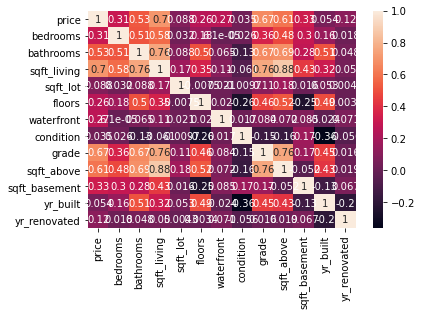

In [40]:
ax  = sns.heatmap(df.corr(), annot = True)

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']
X = df[features]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif["features"] = df[features].columns
vif

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,23.133758,bedrooms
1,25.136070,bathrooms
2,inf,sqft_living
3,1.201943,sqft_lot
4,16.105639,floors
5,1.031492,waterfront
6,30.043422,condition
7,127.657598,grade
8,inf,sqft_above
9,inf,sqft_basement


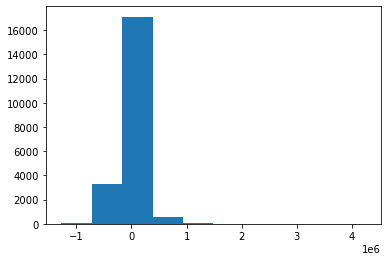

In [42]:
lr.fit(x, y)
preds = lr.predict(x)
residuals = y-preds
plt.hist(residuals)
plt.show()

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


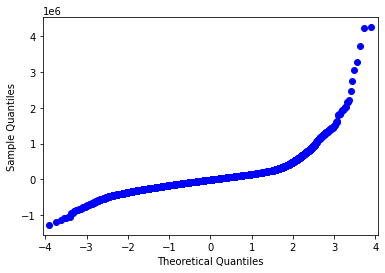

In [43]:
fig = sm.qqplot(residuals, line = 'r')

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


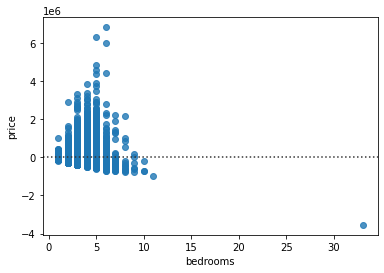

In [44]:
x2 = df['bedrooms']
sns.residplot(x2, y)
plt.show()

In [45]:
df['bedrooms'].value_counts()

3     9639
4     6740
2     2691
5     1560
6      262
1      191
7       36
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64